In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import time
import pickle
import numpy as np
import pandas as pd
import geopandas as gpd
import networkx as nx
import matplotlib.pyplot as plt
from ortools.linear_solver import pywraplp as OR

import load
import optimize
import visualize

%matplotlib inline

In [3]:
tracts = load.load_tract_shapes()

<AxesSubplot:>

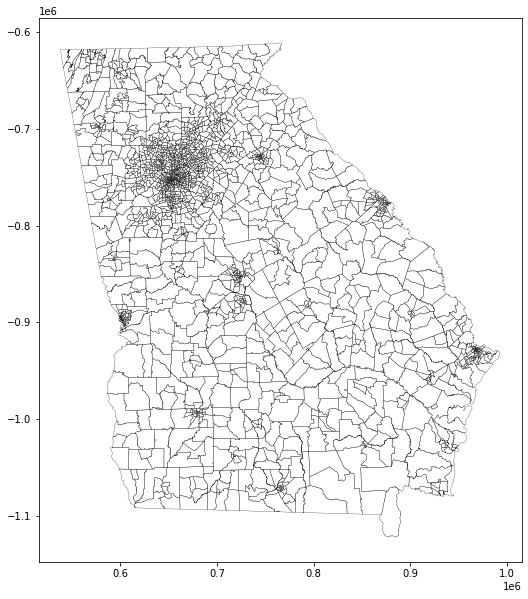

In [4]:
tracts.plot(figsize=(10, 10), color='none', edgecolor='black', lw=.25) 

In [5]:
adjacency_graph = load.load_graph()

<AxesSubplot:>

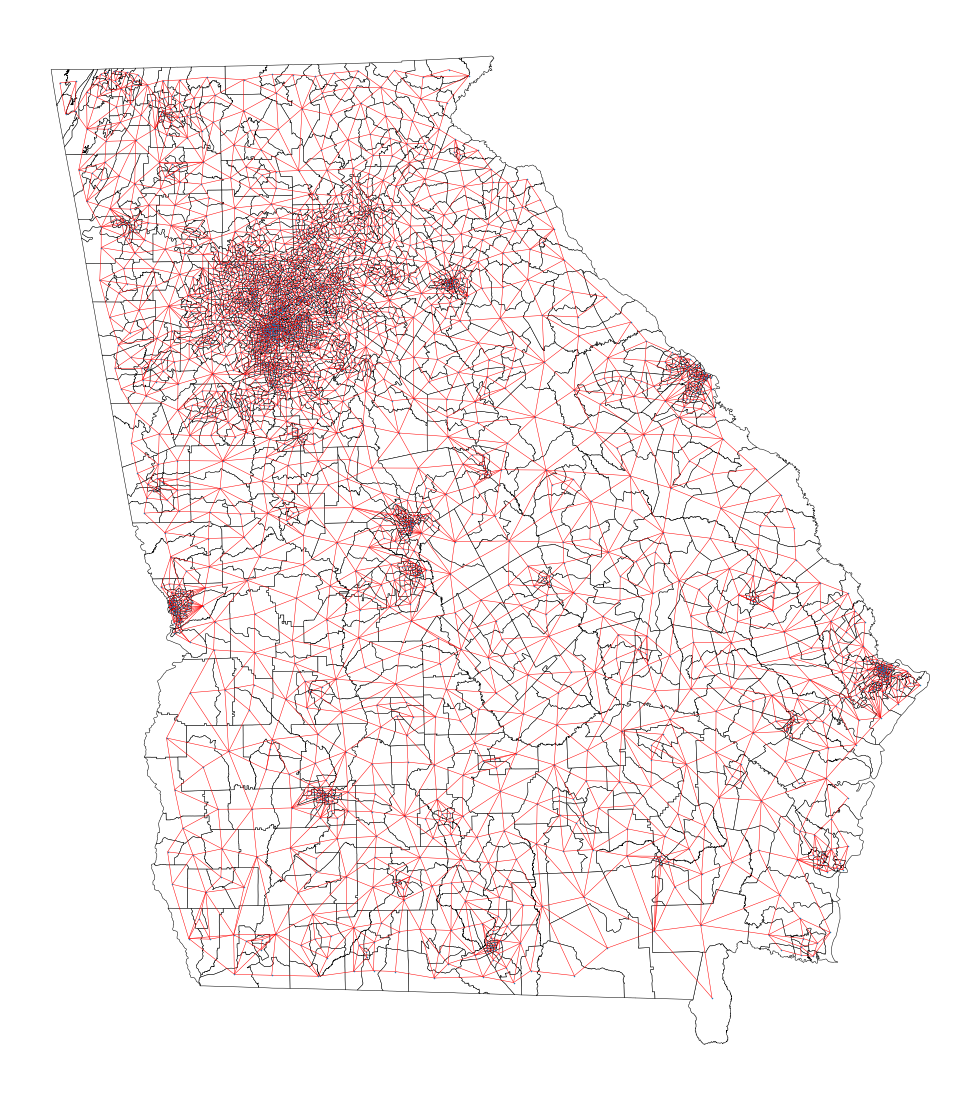

In [6]:
visualize.draw_adjacency_graph(tracts, adjacency_graph, size=(20, 20))

In [7]:
tract_stats = load.load_state_df()
tract_results = load.load_election_df()

In [8]:
tracts['2016_pres'] = tract_results.apply(lambda x: x.R_pres_2016 / (x.R_pres_2016 + x.D_pres_2016), axis=1)

<AxesSubplot:>

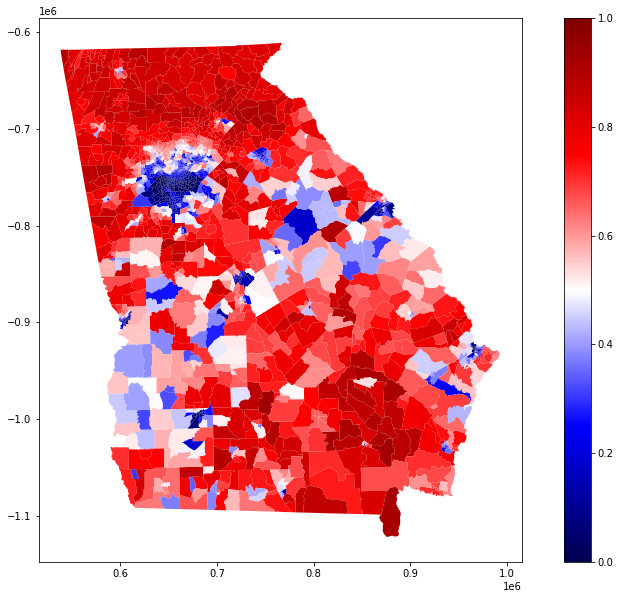

In [9]:
tracts.plot(column='2016_pres', cmap='seismic', vmin=0, vmax=1, figsize=(15, 10), legend=True)

In [10]:
leaf_nodes = pickle.load(open('leaf_nodes.p', 'rb'))
internal_nodes = pickle.load(open('internal_nodes.p', 'rb'))
district_df = pd.read_csv(os.path.join('data', 'ga_district_df.csv'))

In [11]:
block_district_matrix = optimize.make_bdm(leaf_nodes, len(tracts))

In [12]:
block_district_matrix.shape

(1964, 215785)

<AxesSubplot:>

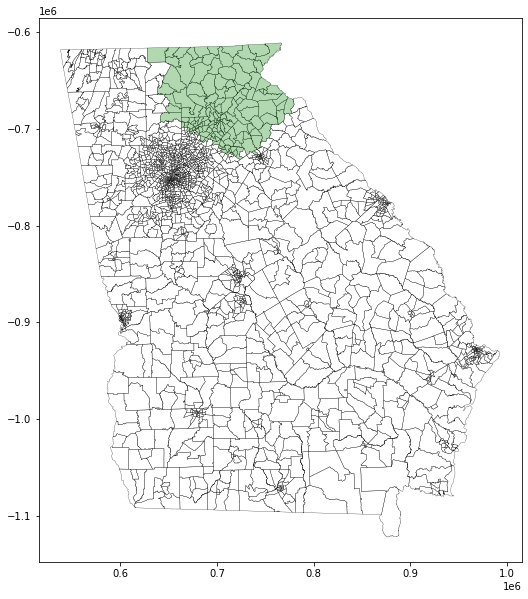

In [13]:
ax = tracts.plot(figsize=(10, 10), color='none', edgecolor='black', lw=.25) 
tracts.iloc[leaf_nodes[0]['area']].plot(ax=ax, color='green', alpha=.3)

In [14]:
n_districts = 14
cost_coeffs = optimize.efficiency_gap_coefficients(district_df, .53)
# Shard sample tree by root partition
partition_map = optimize.make_root_partition_to_leaf_map(leaf_nodes, internal_nodes)

# Solve master selection problem for each shard
sol_dict = {}
for partition_ix, leaf_slice in partition_map.items():
    start_t = time.time()
    m, x = optimize.make_master(n_districts,
                                block_district_matrix[:, leaf_slice],
                                cost_coeffs[leaf_slice], solver='OR-Tools')
    construction_t = time.time()
    
    # OR-Tools
    m.SetTimeLimit(int(len(leaf_nodes) / 10))
    params = OR.MPSolverParameters()
    params.SetDoubleParam(params.RELATIVE_MIP_GAP, 1e-4)
    m.Solve(params)
    opt_cols = [j for j, v in x.items() if v.solution_value() > .5]
    
    # Gurobi
#     m.Params.LogToConsole = 0
#     m.Params.MIPGapAbs = 1e-4
#     m.Params.TimeLimit = len(leaf_nodes) / 10
#     m.optimize()
#     opt_cols = [j for j, v in x.items() if v.X > .5]
    
    solve_t = time.time()
    
    sol_dict[partition_ix] = {
            'construction_time': construction_t - start_t,
            'solve_time': solve_t - construction_t,
            'n_leaves': len(leaf_slice),
            'solution_ixs': partition_map[partition_ix][opt_cols],
            'optimal_objective': cost_coeffs[leaf_slice][opt_cols]
        }
    if partition_ix > 1:
        break # There are 385 shards, just showing 1

In [15]:
obj_vals = np.array([sol_dict[ix]['optimal_objective'].sum() for ix in sol_dict])
best_solution = sol_dict[np.argmin(obj_vals)]

In [16]:
optimal_plan = {ix: leaf_nodes[ix]['area'] for ix in best_solution['solution_ixs']}
district_partisanship = district_df.loc[optimal_plan.keys(), 'mean']

,geometry,color
0,"POLYGON ((604085.722 -756401.695, 604085.824 -...",0.602230
1,"POLYGON ((642703.739 -749381.476, 642545.135 -...",0.415820
2,"POLYGON ((670274.434 -748699.650, 670276.018 -...",0.529489
3,"POLYGON ((656111.994 -751809.625, 656105.914 -...",0.422559
4,"POLYGON ((867751.890 -1102341.962, 867755.788 ...",0.622461
5,"POLYGON ((989837.232 -929123.375, 990531.054 -...",0.489416
6,"POLYGON ((724717.059 -852585.973, 724764.569 -...",0.633611
7,"POLYGON ((609854.900 -828229.418, 609835.121 -...",0.448722
8,"POLYGON ((696314.541 -830017.170, 696315.851 -...",0.286326
9,"POLYGON ((665580.557 -837200.971, 665581.525 -...",0.318986


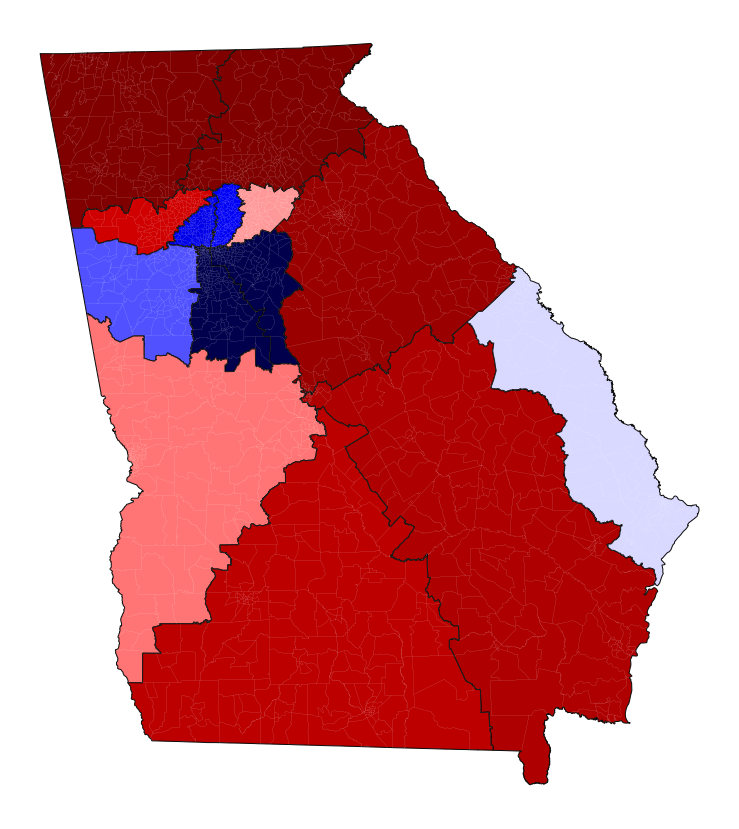

In [17]:
visualize.politics_map(tracts, district_partisanship, optimal_plan)